In [100]:
#Imports

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import hashlib
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [101]:
#Lectura del set de datos y formateo de fecha para selección de año/mes

df = pd.read_csv('/home/nacho/TFM/dataset')
df['Date2'] = pd.to_datetime(df['Date'],format='%Y%m%d')
df['Date2'] = df['Date2'].apply(lambda x: x.strftime('%Y%m'))


In [102]:
#Lectura del fichero de clientes impagados

unpay = pd.read_csv('/home/nacho/TFM/rest_imp_201811191822.csv', sep='|')

unpay['TIME2'] = pd.to_datetime(unpay['TIME'])
unpay['TIME2'] = unpay['TIME2'].apply(lambda x: x.strftime('%Y%m'))
unpay.drop(['user_id', 'TIME', 'channel', 'line_type', 'parque'], axis=1, inplace=True)
unpay.drop_duplicates(inplace=True)

In [103]:
#Mergear ambos ficheros y clasificar las llamadas como impago o no

merged = pd.merge(df, unpay, how='left', left_on=['Date2', 'ids'], right_on=['TIME2', 'subscription_id'])
#unpay.drop_duplicates()
merged.drop(['subscription_id', 'TIME2'],axis=1, inplace=True)
merged['parque_status_description'].fillna(0, inplace=True)
merged['parque_status_description'].replace('RD, Restriccion por deuda', 1, inplace=True)
merged.head()

,ids,Date,Time,Type2,Traffic,Prefix,Duration,type_cust,Date2,parque_status_description
0,89647946,20171224,1900,Llamada internacional zona 1,VOICE_MO,40,22,2,201712,0
1,89647946,20171224,1901,Llamada internacional zona 1,VOICE_MO,40,1134,2,201712,0
2,89647946,20171225,1259,Llamada internacional zona 1,VOICE_MO,40,2125,2,201712,0
3,89647946,20171227,1928,Llamada internacional zona 1,VOICE_MO,40,3354,2,201712,0
4,89647946,20180107,1123,Llamada internacional zona 1,VOICE_MO,40,1537,2,201801,0


In [104]:
#Hasheado de los ids del fichero

ids = merged['ids'].astype(str).values.tolist()
hashed_ids = [abs(hash(i)) % (10 ** 8) for i in ids]

merged['hashed_ids'] = hashed_ids
df_ = merged
df_.drop(['ids'], axis=1, inplace=True)
df_.head()

,Date,Time,Type2,Traffic,Prefix,Duration,type_cust,Date2,parque_status_description,hashed_ids
0,20171224,1900,Llamada internacional zona 1,VOICE_MO,40,22,2,201712,0,43576664
1,20171224,1901,Llamada internacional zona 1,VOICE_MO,40,1134,2,201712,0,43576664
2,20171225,1259,Llamada internacional zona 1,VOICE_MO,40,2125,2,201712,0,43576664
3,20171227,1928,Llamada internacional zona 1,VOICE_MO,40,3354,2,201712,0,43576664
4,20180107,1123,Llamada internacional zona 1,VOICE_MO,40,1537,2,201801,0,43576664


In [105]:
#Generación de csv con dataset final

df_.to_csv('/home/nacho/TFM/ficheros/final_dataset_hashed')

In [106]:
#Popular el campo impago con 0 y 1

df_['parque_status_description'].fillna(0, inplace=True)
df_['parque_status_description'].replace('RD, Restriccion por deuda', 1, inplace=True)
#merged.drop(['subscription_id', 'TIME2'], axis=1, inplace=True)

In [107]:
#Generar dos datasets para ver la cantidad de impagos

unpay = df_[df_['parque_status_description'] == 1 ]
pay = df_[df_['parque_status_description'] == 0]

In [108]:
print(len(unpay['hashed_ids'].unique()))
print(len(pay['hashed_ids'].unique()))
print(df_.shape)

675
24134
(133778, 10)


Text(0, 0.5, '')

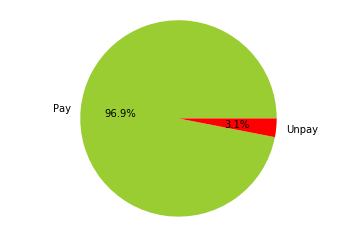

In [109]:
#Vamos a mirar el grado de impago respecto del pago

fig, ax = plt.subplots(1, 1)
ax.pie(df_.parque_status_description.value_counts(),autopct='%1.1f%%', labels=['Pay','Unpay'], 
       colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

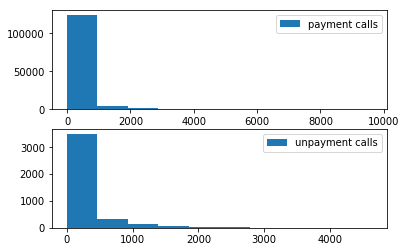

In [111]:
#Revisión de llamadas identificadas con pago/impago

plt.figure(1)
plt.subplot(211)
plt.hist(data=df_[df_['parque_status_description']==0],x='Duration',label='payment calls')
plt.legend(loc='best')
plt.subplot(212)
plt.hist(data=df_[df_['parque_status_description']==1],x='Duration',label='unpayment calls')
plt.legend(loc='best')

In [112]:
#Escalar el valor "Duración"

df_['scaled_duratio'] = StandardScaler().fit_transform(df_['Duration'].values.reshape(-1,1))
df_ = df_.drop(['Duration'],axis=1)

/home/nacho/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nacho/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [113]:
#Label encoding de la variable categórica Type2 (destino de tráfico)

le = preprocessing.LabelEncoder()
df_['Traffic_labeled'] = le.fit_transform(df_['Type2'])

In [114]:
#Ids como indices para no afectar al algoritmo

data = df_.drop(['Traffic','type_cust','Date2', 'Type2'],axis=1)
data.set_index('hashed_ids')

,Date,Time,Prefix,parque_status_description,scaled_duratio,Traffic_labeled
hashed_ids,,,,,,
43576664,20171224,1900,40,0,-0.406277,0
43576664,20171224,1901,40,0,2.244305,0
43576664,20171225,1259,40,0,4.606469,0
43576664,20171227,1928,40,0,7.535934,0
43576664,20180107,1123,40,0,3.204902,0
43576664,20180108,1539,40,0,-0.296630,0
43576664,20180113,1142,40,0,3.185834,0
43576664,20180113,1914,40,0,3.209670,0
43576664,20180114,2025,40,0,0.976221,0


In [115]:
#Separamos el dataset para entrenar el modelo

y = data['parque_status_description']
X = data.drop(['parque_status_description'], axis=1)

In [116]:
#Separamos en bloque de entrenamiento y bloque de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [118]:
#Intentamos calcular el k optimo

k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.989273433996113, 0.9875915682463746, 0.9860218268799522, 0.9847884586634773, 0.983405591269248, 0.9828823441471072, 0.981686350725071, 0.9807893556585439, 0.979967110180894, 0.9789953655254896, 0.978247869636717, 0.9779862460756465, 0.9773508745701899, 0.9769397518313649, 0.9764165047092241, 0.9756690088204515, 0.9753700104649424, 0.9753326356705038, 0.9745477649872926, 0.9739497682762744, 0.9735386455374495, 0.9736133951263268, 0.9732770219763791, 0.973090148004186, 0.9726416504709224]


Text(0, 0.5, 'Precision')

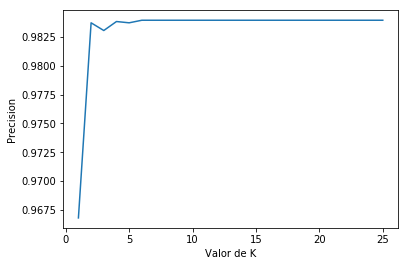

In [130]:
# Ploteamos los valores de k
plt.plot(k_range, scores)
plt.xlabel('Valor de K')
plt.ylabel('Precision')

In [117]:
#Entrenamos el modelo

knn = KNeighborsClassifier(n_neighbors = 3,n_jobs=16)
knn.fit(X_train,y_train)
score = knn.score(X_test,y_test)
print("model evaluated")
print(score)
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

classifier created
model evaluated
0.9860218268799522
Accuracy: 0.9860218268799522


In [120]:
#Matriz de confusión

pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[25753   184]
 [  548   271]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     25937
           1       0.60      0.33      0.43       819

   micro avg       0.97      0.97      0.97     26756
   macro avg       0.79      0.66      0.71     26756
weighted avg       0.97      0.97      0.97     26756



In [121]:
#Segundo acercamiento
#Agrupamos por cliente y por mes

grouped = df_.groupby(['hashed_ids', 'Date2']).sum()
grouped.head()

Date  Time  Prefix  type_cust  \
hashed_ids Date2                                       
4030       201807  20180715  1314      86          2   
4339       201805  20180515  2029      44          0   
           201807  20180703  1409      44          0   
5304       201806  20180630  2108      49          0   
6404       201805  40361056  2211     172          4   

                   parque_status_description  scaled_duratio  Traffic_labeled  
hashed_ids Date2                                                               
4030       201807                          0       -0.260876                4  
4339       201805                          0       -0.418195                0  
           201807                          0        0.101434                0  
5304       201806                          0        1.159759                0  
6404       201805                          0        2.503057                8

In [122]:
#Seleccionamos las columnas para entrenar el modelo

grouped_knn = grouped[['Prefix', 'scaled_duratio', 'Traffic_labeled', 'parque_status_description']]
grouped_knn

Prefix  scaled_duratio  Traffic_labeled  \
hashed_ids Date2                                             
4030       201807      86       -0.260876                4   
4339       201805      44       -0.418195                0   
           201807      44        0.101434                0   
5304       201806      49        1.159759                0   
6404       201805     172        2.503057                8   
           201807      86       -0.422962                4   
18881      201709    2100       -1.075553                5   
           201710    1542        0.052960                2   
           201711     351        1.109704                0   
           201712    1260       -1.216446                3   
           201801    1191       -0.968550                2   
           201802    1260       -0.372646                3   
           201803    1542        1.447375                2   
           201804    5811        1.448675               13   
           201805    1611        3.394790                3   
           201806    3717        9.948132                3   
           201807     840       -0.314377                2   
30822      201805      66        0.350652                0   
           201806      97       -0.098530                0   
32248      201710     399       -2.249896                6   
           201712     135        0.301917                6   
           201801     255       -1.936038               15   
           201802     216       -2.425742                3   
           201805      51        1.550673                3   
35541      201710      64       -0.645700                0   
37202      201805      33        0.161024                0   
38400      201802     702        0.360186                0   
           201803   20272       -3.369265                0   
39722      201802      39        3.500471                0   
44253      201805      44       -0.272794                0   
...                   ...             ...              ...   
99908389   201711     795       -5.878584                0   
           201712     471       -4.138522                0   
           201801     416       -3.138725                0   
99910320   201803      44       -0.444414                0   
99911553   201709      66       -0.159442                0   
           201710      99       -0.355961                0   
           201711      66       -0.054563                0   
99915784   201803     593       -0.220355                3   
99919664   201805      96       -0.489443                0   
           201806      32        0.632980                0   
99921774   201709      96        0.117057                0   
99922410   201801       2       -0.879295                4   
99929067   201806     135       -0.270150                0   
99929487   201710      82       -0.352515                2   
           201711      41       -0.396742                1   
           201801      41       -0.442031                1   
           201803      82        0.698660                2   
99933884   201804      41       -0.432496                1   
           201807     702       -0.042645                0   
99934935   201807      49       -0.444414                0   
99939418   201806      78       -0.886445                0   
99958057   201712      33       -0.451565                0   
99974142   201801      33       -0.420578                0   
99977594   201805      58       -0.451565                3   
99984080   201708      66       -0.860226                0   
99984651   201712     376       -0.167915                1   
99987444   201802       1       -0.451565                2   
99990396   201801      44       -0.365755                0   
99996112   201804     351       -0.234656                0   
           201806     351       -0.055885                0   

                   parque_status_description  
hashed_ids Date2                              
4030       201807 

In [123]:
#Separamos el set para entrenar el modelo

y2 = grouped_knn['parque_status_description']
X2 = grouped_knn.drop(['parque_status_description'], axis=1)

In [124]:
#Separamos en set de entrenamiento y de test

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

In [125]:
#Intentamos calcular el k optimo

k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train2, y_train2)
    y_pred2 = knn.predict(X_test2)
    scores.append(metrics.accuracy_score(y_test2, y_pred2))

print(scores)

[0.9668040548067283, 0.9837362147710816, 0.9830678400356466, 0.9838476105603208, 0.9837362147710816, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956, 0.98395900634956]


Text(0, 0.5, 'Precisión')

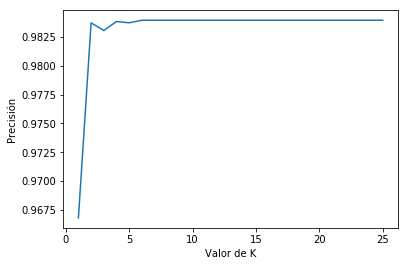

In [131]:
#Ploteamos los valores de k

plt.plot(k_range, scores)
plt.xlabel('Valor de K')
plt.ylabel('Precisión')

In [132]:
#Entrenamos el modelo

knn = KNeighborsClassifier(n_neighbors = 7,n_jobs=16)
knn.fit(X_train2,y_train2)
score2 = knn.score(X_test2,y_test2)
y_pred2 = knn.predict(X_test2)
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))

Accuracy: 0.98395900634956


In [133]:
#MAtriz de confusión

pred2 = knn.predict(X_test2)
print(confusion_matrix(y_test2, pred2))
print(classification_report(y_test2, pred2))

[[8833    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  44    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  24    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  11    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  15    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   8    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   7    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   6    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   4    

/home/nacho/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
